# Парсер с Lenta.ru новости https://lenta.ru/search

In [4]:
import requests
import threading
from bs4 import BeautifulSoup
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import time
import random

%matplotlib inline
import matplotlib.pyplot as plt

url = 'https://newssearch.yandex.ru/yandsearch?rpt=nnews2&rel=rel&within=9'
HEADER = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
          'accept': '*/*'}
r = requests.get(url, headers = HEADER)
soup = BeautifulSoup(r.content.decode('utf-8','ignore'), 'html.parser')
news = []
for link in soup.find_all('li', class_ =  'search-item'):
    news+=[link.text]
news

for i in tqdm(range(100)):
    r = requests.get(url, headers = HEADER)
    soup = BeautifulSoup(r.content.decode('utf-8','ignore'), 'html.parser')
    if len(soup.find_all('li', class_ =  'search-item')):
        print(123)    
soup

In [ ]:
# url_searcher = 'https://lenta.ru/news/2020/05/21'
# # url_searcher = 'https://lenta.ru/news/2016/05/21/ducks'

In [ ]:
# HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
#                          'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
#           'accept': '*/*'}

# r = requests.get(url_searcher)#,params = PARAMS , headers = HEADERS
# soup = BeautifulSoup(r.text, 'html.parser')#html.parser
# # soup

# # len_news = int(soup.find_all('div', class_ =  'b-search__result-item-title'))#[0].text.split(' ')[0]
# # len_news

In [1]:
def soup_item_to_dict(s_item):
  times = s_item.find('span' ,class_="g-date item__date").text
  item_dict = {}
  item_dict['time'] = times[:5]
  if times[8:]==' ':
    item_dict['date'] = times[9:]
  else:
    item_dict['date'] = times[8:]
  item_dict['link'] = 'https://lenta.ru' + s_item.find('a').get('href')
  item_dict['headline'] = s_item.find('div', class_="titles").find('span').text.replace('\xa0', ' ')
  return item_dict

# soup_item_to_dict(topic_news[0])

In [2]:
days_in_month_dict ={
    1:31,
    2:29,
    3:31,
    4:30,
    5:31,
    6:30,
    7:31,
    8:31,
    9:30,
    10:31,
    11:30,
    12:31
}

# сбор новостей_0

In [4]:
topic_news = []
month = 4

base_url = 'https://lenta.ru/news/2020/0' + str(month) + '/'
days_in_month = days_in_month_dict[month]
print(f'{month} - {days_in_month}')
for day_id in tqdm(range(1, days_in_month+1)):
  now_day_str = str(day_id)
  if len(now_day_str)==1:
    now_day_str='0'+now_day_str
  now_day_str = base_url+now_day_str
  try:
    r = requests.get(now_day_str)
    soup = BeautifulSoup(r.text, 'html.parser')
    now_day_items = soup.find_all('div', class_ =  'item news b-tabloid__topic_news')
    topic_news.extend(now_day_items)

    if len(now_day_items)==0:
      print('now_day_items is NOT define')


  except:
    print(str(day_id)+' error')

len(topic_news)
topic_news_dict = [soup_item_to_dict(tn) for tn in topic_news]
len(topic_news_dict)

4 - 30


7553

In [5]:
topic_news_dict[-3:]

[{'date': '30 апреля 2020',
  'headline': 'В правительстве России рассказали о дальнейшей работе',
  'link': 'https://lenta.ru/news/2020/04/30/zasedanie/',
  'time': '22:36'},
 {'date': '30 апреля 2020',
  'headline': 'Создатели папах для Хабиба Нурмагомедова заразились коронавирусом',
  'link': 'https://lenta.ru/news/2020/04/30/papakhi/',
  'time': '23:01'},
 {'date': '30 апреля 2020',
  'headline': 'Россию сочли вышедшей на плато по коронавирусу',
  'link': 'https://lenta.ru/news/2020/04/30/plato_rssa/',
  'time': '23:37'}]

# сбор новостей

In [ ]:
max_time_delay = 0

In [5]:
lock = threading.Lock()

def take_text_and_tag_news(id, now_link):
  time_delay = time.time()
  
  tag =''
  st=''
  flag = True
  iterator_0 = 0
  while flag and iterator_0<10:
    iterator_0+=1

    r = requests.get(now_link)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    try:
      tag = soup.find('a', class_ = 'b-header__block').text
      sp = soup.find('div', class_ = 'b-text')
      st = ''
      for s_ in sp.find_all('p'):
        st+=s_.text + ' '
    except:
      pass

    if tag!='':
      flag = False
    else:
      time.sleep(0.1)

  if tag=='':
    print('tag NOT defined (((')
  time_delay = time.time() - time_delay
  global max_time_delay
  global news
  with lock:
      max_time_delay = max(max_time_delay, time_delay)
      news.extend([(id,tag, st)])

  if id%500==0:
    print(f'{id} {tag}')
  return tag, st

# take_text_and_tag_news(0, 'https://lenta.ru/news/2020/12/01/nervy/')

In [ ]:
len(topic_news_dict)

7809

In [7]:
news = []
max_time_delay=0
max_thread_number = 30
threads_index = set([])


arr_news_of_time = time.time()

thrs_main = [threading.Thread(target=take_text_and_tag_news, args= (i, tnd['link'],)) 
              for i, tnd in enumerate(topic_news_dict)]

now_threads = set([])

iterator = 0

while iterator<len(thrs_main):
  finished_threads=set([])
  for th in now_threads:
    if not th.isAlive():
      finished_threads.add(th)
  now_threads-=finished_threads
  
  while len(now_threads)<max_thread_number:
    try:
      now_threads.add(thrs_main[iterator])
      thrs_main[iterator].start()
      iterator+=1
      time.sleep(0.01)
    except:
      print(f'iterator: {iterator}')
      break
  time.sleep(0)


# for ths in thrs_main:
#   time.sleep(0.1)
#   ths.start()

for ths in thrs_main:
  ths.join()

print(time.time()-arr_news_of_time)
print(f'max_time_delay {max_time_delay}')
len(news)

1 Мир
19 Россия
17 Мир
3 Экономика
0 Экономика
9 Экономика
13 Экономика8 Наука и техника
21 Интернет и СМИ
16 Россия6 Из жизни

4 Мир20 Россия


29 Россия
24 Россия
23 Спорт
14 Наука и техника12 Мир
18 Бывший СССР

22 Ценности
2 Из жизни
5 Экономика
15 Из жизни
25 Россия
11 Путешествия
26 Наука и техника
27 Экономика
10 Дом
7 Мир
28 Спорт
31 Мир
30 Ценности
32 Силовые структуры
33 Спорт
35 Россия
36 Путешествия
37 Россия
38 Мир
34 Бывший СССР
39 Россия
41 Россия
44 Россия
42 Наука и техника
40 Ценности
43 Нацпроекты
46 Мир
45 Бывший СССР
48 Россия47 Бывший СССР

51 Интернет и СМИ
49 Путешествия
52 Экономика
54 Ценности
56 Россия
50 Бывший СССР
60 Нацпроекты
58 Нацпроекты
63 Экономика
57 Россия
59 Нацпроекты
61 Силовые структуры
53 Мир
65 Путешествия
68 Путешествия
66 Россия
70 Россия
62 Наука и техника
55 Экономика71 Бывший СССР
67 Россия
72 Ценности

64 Культура
73 Россия
74 Россия
75 Бывший СССР
69 Ценности
78 Россия
76 Путешествия
77 Россия
81 Россия
80 Экономика
79 Спорт
83 Россия


Exception in thread Thread-360:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



336 Россия361 Дом

368 Россия363 Экономика

358 Из жизни
362 Культура
365 Экономика
367 Бывший СССР
364 Нацпроекты
369 Россия
372 Экономика
373 Россия
371 Интернет и СМИ
374 Экономика
370 Мир
376 Россия
378 Мир
384 Россия
383 Россия380 Россия

359 Силовые структуры375 Нацпроекты

377 Бывший СССР
382 Экономика
381 Россия
379 Силовые структуры
386 Спорт
385 69-я параллель
388 Силовые структуры
389 Россия
387 Силовые структуры
393 Мир
335 Путешествия392 Экономика

390 Из жизни
394 Ценности
366 Россия391 Силовые структуры

395 Мир
396 Спорт
400 Дом
397 Мир
399 Россия
401 Мир
398 Наука и техника
402 Мир
403 Россия
405 Интернет и СМИ
408 Россия404 Из жизни

411 Россия
409 Интернет и СМИ
406 Наука и техника
407 Спорт
410 Экономика
414 Бывший СССР
415 Экономика
419 Интернет и СМИ
416 Силовые структуры
417 Нацпроекты
422 Экономика412 Путешествия413 Бывший СССР


418 Дом
423 Дом
425 Россия
424 Мир
421 Культура
428 Из жизни
427 Дом
431 Силовые структуры
420 Культура
429 Мир
430 Россия
426 Россия


Exception in thread Thread-4146:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



4139 Интернет и СМИ
4140 Культура
4142 Путешествия
4145 Экономика
4147 Мир4152 Россия

4144 Силовые структуры
4148 Россия
4149 Интернет и СМИ4166 Россия

4154 Бывший СССР
4169 Россия
4151 Мир
4153 Россия4143 Россия4156 Россия
4155 Интернет и СМИ

4163 Россия

4157 Россия
4158 Дом
4146 Россия4167 Интернет и СМИ
4160 Россия

4162 Наука и техника
4165 Силовые структуры
4159 Спорт
4168 Россия
4161 Нацпроекты
4173 Путешествия
4164 Из жизни
4171 Силовые структуры
4170 Культура4175 Силовые структуры
4174 Спорт

4150 Наука и техника
4172 Наука и техника
4180 Россия
4177 Интернет и СМИ
4176 Силовые структуры
4178 Дом
4179 Из жизни
4183 Бывший СССР
4181 Россия
4185 Россия
4182 Наука и техника
4186 Культура
4184 Интернет и СМИ
4192 Мир
4193 Дом
4190 Нацпроекты4197 Россия

4199 Нацпроекты4191 Силовые структуры4194 Россия
4198 Россия


4189 Бывший СССР
4188 Россия
4187 Бывший СССР4195 Силовые структуры

4196 Россия
4201 Ценности
4204 Россия
4200 Наука и техника
4205 Силовые структуры
4203 Спорт
420

Exception in thread Thread-4435:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



4428 Мир
4419 Спорт4434 Наука и техника
4432 Спорт
4427 Мир

4436 Россия
4431 Россия
4440 Россия
4424 Мир
4446 Россия
4433 Россия4443 Мир
4429 Бывший СССР
4421 Культура
4444 Силовые структуры
4435 Россия

4439 Ценности
4449 Наука и техника4441 Россия

4445 Россия4442 Россия

4438 Ценности
4448 Силовые структуры
4437 Спорт
4447 Интернет и СМИ
4452 Экономика
4450 Наука и техника
4451 Из жизни
4453 Россия
4454 Спорт
4456 Бывший СССР
4458 Россия
4459 Россия
4455 Интернет и СМИ
4457 Бывший СССР
4461 Россия
4462 Россия
4465 Россия
4466 Россия
4469 Россия
4475 Россия
4472 Россия
4471 Россия
4468 Мир
4476 Россия
4473 Спорт
4470 Мир
4477 Россия4478 Россия

4480 Россия
4474 Экономика
4460 Россия
4483 Россия
4486 Россия
4479 Экономика
4485 Наука и техника
4481 Спорт4482 Бывший СССР4489 Интернет и СМИ
4491 Бывший СССР


4488 Дом
4467 Мир4490 Культура
4487 Дом

4464 Культура
4494 Россия
4492 Россия
4484 Бывший СССР
4493 Спорт
4495 Экономика
4496 Россия4497 Россия

4499 Мир4463 Спорт
4498 Наука и те

Exception in thread Thread-4515:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



4507 Путешествия
4505 Культура
4511 Россия
4515 Россия
4506 Россия
4514 Россия
4509 Культура
4516 Мир
4517 Россия
4508 Россия4519 Россия

4513 Культура
4522 Силовые структуры
4524 Наука и техника
4512 Спорт
4530 Россия
4526 Спорт
4525 Россия
4521 Экономика
4533 Россия4503 Наука и техника
4520 Спорт

4523 Экономика4528 Из жизни
4518 Культура
4527 Интернет и СМИ
4532 Спорт

4536 Мир4534 Мир

4535 Россия
4529 Россия
4531 Из жизни
4537 Спорт
4539 Мир
4538 Спорт
4540 Мир
4541 Мир
4542 Мир
4544 Мир
4543 Мир4557 Россия

4550 Мир
4548 Россия
4545 Мир
4547 Россия
4546 Бывший СССР
4552 Спорт
4555 Россия
4549 Россия
4551 Россия
4554 Культура
4563 Россия
4569 Россия4560 Россия

4558 Россия
4566 Россия
4564 Наука и техника4553 Силовые структуры

4556 Интернет и СМИ
4571 Спорт4567 Россия

4559 Интернет и СМИ
4561 Спорт
4570 Россия
4573 Россия
4568 Россия
4572 Спорт
4574 Россия
4565 Экономика
4577 Россия4576 Мир
4575 Наука и техника

4579 Россия
4562 Бывший СССР
4578 Наука и техника
4581 Россия
4582 

Exception in thread Thread-4682:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



4681 Экономика
4684 Ценности4680 Бывший СССР
4679 Экономика

4687 Россия4686 Мир
4682 Экономика
4683 Бывший СССР

4689 Россия
4688 Россия
4694 Россия
4693 Россия
4691 Россия
4685 Бывший СССР4690 Экономика

4700 Мир
4696 Россия
4695 Путешествия
4697 Из жизни
4692 Интернет и СМИ
4704 Силовые структуры4707 Мир
4705 Ценности4698 Дом

4706 Интернет и СМИ
4710 Силовые структуры

4702 Бывший СССР
4709 Экономика
4701 Силовые структуры
4708 Бывший СССР
4713 Россия
4712 Путешествия
4699 Силовые структуры
4714 Россия
4711 Наука и техника
4715 Россия
4703 Путешествия
4716 Мир4718 Бывший СССР
4717 Ценности

4719 Нацпроекты
4720 Россия
4721 Культура
4722 Путешествия
4727 Мир
4723 Россия
4725 Россия
4726 Россия
4728 Дом
4731 Мир
4729 Нацпроекты
4724 Россия
4730 Бывший СССР
4732 Спорт
4735 Россия
4733 Бывший СССР
4739 Бывший СССР
4737 Из жизни
4736 Путешествия
4742 Из жизни
4745 Экономика
4754 Ценности
4753 Экономика
4751 Россия4738 Экономика4740 Наука и техника


4752 Наука и техника4755 Экономика

4

Exception in thread Thread-5283:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-11498b6ed58e>", line 14, in take_text_and_tag_news
    tag = soup.find('a', class_ = 'b-header__block').text
AttributeError: 'NoneType' object has no attribute 'text'



5280 Мир5276 Путешествия5288 Россия
5285 Путешествия

5287 Ценности

5281 Силовые структуры
5279 Спорт
5283 Экономика
5286 Мир
5290 Спорт5291 Россия

5289 Россия
5295 Путешествия5296 Наука и техника
5300 Россия

5293 Из жизни
5282 Наука и техника
5298 Россия
5268 Экономика
5294 Россия
5284 Силовые структуры
5292 Дом
5299 Из жизни
5301 Путешествия
5302 Мир
5297 Нацпроекты
5304 Экономика
5305 Из жизни
5306 Экономика
5307 Россия
5303 Ценности
5308 Экономика
5313 Из жизни
5310 Культура
5309 Мир
5311 Россия
5314 Россия5315 Силовые структуры

5312 Силовые структуры
5317 Экономика
5319 Бывший СССР
5325 Нацпроекты5324 Нацпроекты

5322 Спорт
5328 Россия
5323 Мир
5318 Россия
5316 Интернет и СМИ5330 Силовые структуры

5332 Путешествия
5331 Из жизни
5327 Нацпроекты
5336 Силовые структуры
5337 Ценности
5329 Наука и техника
5334 Наука и техника
5340 Из жизни
5333 Спорт
5321 Экономика
5320 Культура
5326 Нацпроекты
5339 Мир
5335 Наука и техника5343 Мир

5338 Спорт
5344 Путешествия5341 Наука и техника


7547

In [9]:
news[-100]

(7441,
 'Спорт',
 'Российский боец UFC Александр Волков в Instagram отреагировал на угрозы соотечественника Магомеда Исмаилова в адрес звезды «Реальных пацанов» Николая Наумова. Волков посчитал, что каждый имеет право на собственное мнение. «Нас, бойцов, это не красит — если мы будем угрожать всем, кто на нас не ставит, тем более не из мира спорта. Есть у нас общие знакомые с Николаем, поэтому, Магомед, я в обиду его не дам», — заявил спортсмен. 29 апреля Исмаилов опубликовал в Instagram отрывок из интервью Наумова, в котором тот назвал бойца шоуменом и предрек ему поражение в поединке против Александра Емельяненко. В ответ Исмаилов пригрозил Наумову «поменять окрас шеи на бордово-красный». На счету Волкова 31 победа и семь поражений в поединках по правилам MMA. Последний раз спортсмен выходил в октагон 9 ноября 2019-го на московском турнире UFC. Тогда он одолел американца Грега Харди, который заменил снявшегося с боя Джуниора Дос Сантоса. ')

In [10]:
qwe = [_[0]=='' for _ in news]
np.array(qwe).sum()

0

In [11]:
for n in news:
  topic_news_dict[n[0]]['tag'] = n[1]
  topic_news_dict[n[0]]['text'] = n[2]

In [12]:
topic_news_dict[0]

{'date': ' 1 апреля 2020',
 'headline': 'В России выросли минимальные пенсии',
 'link': 'https://lenta.ru/news/2020/04/01/pension/',
 'tag': 'Экономика',
 'text': 'В России с 1 апреля 2020 года социальные пенсии выросли на 6,1 процента в связи с индексацией. Соответствующее постановление премьер-министр Михаил Мишустин подписал 13 марта. О планирующейся индексации минимальных пенсий известно в феврале 2020 года. По данным Минтруда, она коснулась 4 миллионов россиян. Расходы на повышение социальных пенсий составят 2,41 миллиарда рублей в месяц. Таким образом, до конца года на индексацию потратят 21,7 миллиарда рублей. Получателями социальных пенсий являются россияне, которые в силу обстоятельств не заработали трудовой стаж, необходимый для страховой пенсии. В Минтруда заявили, что такие получатели социальных пенсий являются самой малочисленной группой российских пенсионеров. ',
 'time': '00:16'}

In [13]:
dates = [t['date'] for t in topic_news_dict]
len(np.unique(dates))

30

# Все месяцы за раз

In [7]:
for mount_id in tqdm(range(6,10)):

  topic_news = []
  month = mount_id

  base_url = 'https://lenta.ru/news/2020/0' + str(month) + '/'
  days_in_month = days_in_month_dict[month]
  print(f'{month} - {days_in_month}')
  for day_id in tqdm(range(1, days_in_month+1)):
    now_day_str = str(day_id)
    if len(now_day_str)==1:
      now_day_str='0'+now_day_str
    now_day_str = base_url+now_day_str
    try:
      r = requests.get(now_day_str)
      soup = BeautifulSoup(r.text, 'html.parser')
      now_day_items = soup.find_all('div', class_ =  'item news b-tabloid__topic_news')
      topic_news.extend(now_day_items)

      if len(now_day_items)==0:
        print('now_day_items is NOT define')


    except:
      print(str(day_id)+' error')

  len(topic_news)
  topic_news_dict = [soup_item_to_dict(tn) for tn in topic_news]
  print(f'total len: {len(topic_news_dict)}')


  news = []
  max_time_delay=0
  max_thread_number = 50
  threads_index = set([])


  arr_news_of_time = time.time()

  thrs_main = [threading.Thread(target=take_text_and_tag_news, args= (i, tnd['link'],)) 
                for i, tnd in enumerate(topic_news_dict)]

  now_threads = set([])

  iterator = 0

  while iterator<len(thrs_main):
    finished_threads=set([])
    for th in now_threads:
      if not th.isAlive():
        finished_threads.add(th)
    now_threads-=finished_threads
    
    while len(now_threads)<max_thread_number:
      try:
        now_threads.add(thrs_main[iterator])
        thrs_main[iterator].start()
        iterator+=1
        time.sleep(0.01)
      except:
        print(f'iterator: {iterator} total len: {len(thrs_main)}')
        break
    time.sleep(0)


  # for ths in thrs_main:
  #   time.sleep(0.1)
  #   ths.start()

  for ths in thrs_main:
    ths.join()

  print(time.time()-arr_news_of_time)
  print(f'max_time_delay {max_time_delay}')
  len(news)

  for n in news:
    topic_news_dict[n[0]]['tag'] = n[1]
    topic_news_dict[n[0]]['text'] = n[2]


  data = pd.DataFrame(topic_news_dict)
  data.head()


  data.to_pickle(md+"data/news_lenta_0"+ str(mount_id)+ "_2020")

6 - 30



total len: 7622
0 Наука и техника
500 Мир
1000 Россия
1500 Россия
2000 Мир
2500 Силовые структуры
3000 Нацпроекты
3500 Россия
4000 Культура
4500 Мир
5000 Культура
5500 Дом
6000 Силовые структуры
6500 Мир
7000 Мир
7500 Бывший СССР
iterator: 7622 total len: 7622
527.9477832317352
max_time_delay 6.661964178085327
7 - 31



total len: 7816
0 Россия
500 Наука и техника
1000 Наука и техника
1500 Силовые структуры
2000 Мир
2500 Интернет и СМИ
3000 Ценности
3500 Силовые структуры
4000 Спорт
4500 Культура
tag NOT defined (((
5000 Наука и техника
5500 Наука и техника
6000 Мир
6500 Культура
7000 Мир
7500 Из жизни
iterator: 7816 total len: 7816
566.1030249595642
max_time_delay 13.43178915977478
8 - 31



total len: 7508
0 Путешествия
500 Из жизни
1000 Интернет и СМИ
1500 69-я параллель
2000 Ценности
2500 Спорт
3000 Интернет и СМИ
3500 Нацпроекты
4000 Мир
4500 Бывший СССР
5000 Экономика
tag NOT defined (((
5500 Интернет и СМИ
6000 Путешествия
6500 Ценности
7000 Мир
iterator: 7508 total len: 7508
7500 Россия
593.0347418785095
max_time_delay 12.401506423950195
9 - 30



total len: 7727
0 Россия
500 Мир
1000 Нацпроекты
1500 Экономика
2000 Бывший СССР
2500 Россия
3000 Мир
3500 Бывший СССР
4000 Силовые структуры
4500 Ценности
5000 Бывший СССР
5500 Россия
6000 Экономика
6500 Наука и техника
7000 Россия
7500 Из жизни
iterator: 7727 total len: 7727
599.6936657428741
max_time_delay 7.346261739730835



In [8]:
2+2


4

# остатки от риа новости


In [ ]:
url = 'https://ria.ru/search/'
# url = 'https://ria.ru/services/search/getmore/?query=&amp;offset=20&amp;interval=week'

HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
          'accept': '*/*'}

# /services/search/getmore/?query=&offset=20&interval=period&date_from=2020-12-18&date_to=2020-12-25

PARAMS = {'interval': "period",
          'date_from':'2020-08-31',
          'date_to':'2020-08-31',
          'offset': 0}
          
r = requests.get(url,params = PARAMS)
soup = BeautifulSoup(r.text, 'html.parser')

# len_news = int(soup.find_all('div', class_ =  'rubric-count m-active')[0].text.split(' ')[0])
# len_news

In [ ]:
soup.find_all('div', class_ =  'rubric-count m-active')

[<div class="rubric-count m-active"><span>811</span> материалов</div>]

In [ ]:
item = soup.find_all('div', class_ =  'list-item')[0]
item.text

'Экипаж МКС сузил зону поиска утечки воздуха 30 сентября 2020, 23:505738'

In [ ]:
def take_ria_news(url_one):
    r=requests.get(url_one).text
    bs = BeautifulSoup(r, 'html.parser')

    tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 

    texts = bs.find_all('div', class_ = 'article__block')
    main_text = ''
    for _ in texts:
        t = _.find('div',class_ ="article__quote")
        if not t is None:
            main_text += t.text+' '

        t = _.find('div',class_ ="article__text")
        if not t is None:
            main_text += t.text+' '

    return tags, main_text

# take_ria_news(news_ria['link'])

In [ ]:
def take_news(link): # просматривает новость на ria search

    new_item = {}
    new_item['date'] = link.find('div', class_="list-item__date").text.split(', ')[0]
    new_item['time'] = link.find('div', class_="list-item__date").text.split(', ')[1]
    new_item['views'] = int(link.find('div', class_='list-item__views-text').text)
    
    new_item['headline'] = link.find('span',class_="share").get('data-title')
    new_item['link']= link.find('a').get('href')
    new_item['tags'] = []
    new_item['text'] = ''


#     flag = new_item['link'].find('https://ria.ru')!=-1 or new_item['link'].find('https://rsport.ria.ru')!=-1
    flag = new_item['link'].find('ria.ru')!=-1
    
    if (flag):
        try_to_get_tags_and_text = True
        try_counter = 0

        while try_to_get_tags_and_text: 
          try_counter+=1

          # if try_counter%10==0:
          #   print(f't&t pars processing - {try_counter} try')


          if try_counter>20:
            print("dont getted tags and text "+ str(new_item['link']))
            try_to_get_tags_and_text = False
            continue

          try:
            new_item['tags'], new_item['text'] = take_ria_news(new_item['link']) #, new_item['text']
          except:
            print("smth is wrong with t&t")
          if new_item['text']=='':
            time.sleep(random.uniform(0.01,0.1)+ try_counter//10)
            time.sleep(0)
          else:
            try_to_get_tags_and_text = False
            # if try_counter>1:
            #   print(f'success t&t pars with {try_counter} try')
              
    else:
      print("we have not news_text on link "+str(link))
    return new_item
    
# take_news(item)



**Сбор новостей**

In [ ]:
MIN_VIEWS_ON_NEWS = 10000 #отсев новостей с менее 10к просмотров

({'date_from': '2020-08-1',
  'date_to': '2020-08-30',
  'interval': 'period',
  'offset': 123},
 {'date_from': '2020-08-1',
  'date_to': '2020-08-30',
  'interval': 'period',
  'offset': 0})

In [ ]:
lock = threading.Lock()

def take_1_news(news_item):

  # print(f'ones started')
  views_on_news = int(news_item.find('div', class_='list-item__views-text').text)

  flag = news_item.find('a').get('href').find('radiosputnik.ria.ru')==-1 and \
      views_on_news>MIN_VIEWS_ON_NEWS 

  # flag=True # потом не забыть урбрать

  if flag: 
      news_one = take_news(news_item)
      global news
      with lock:
        news.extend([news_one])
  #     print(f'ones finished_ {views_on_news}')
  # else:
  #     print(f'ones cant finished_ {views_on_news} _!')


def take_20_news(i, par):
  # try:
  # print(f'{i} started')
  one_news_of_time = time.time()

  offset = i*20
  params = par.copy()
  params['offset'] = offset

  # print(f'{i} {params}')

  success_try_to_parsing = True
  try_counter=0

  while success_try_to_parsing:
    try_counter+=1
    r = requests.get(url,params = params)
    soup = BeautifulSoup(r.text, 'html.parser')
    # print(f'{i} {params}')

    thrs = [threading.Thread(target=take_1_news, args= (news_item,)) 
            for news_item in soup.find_all('div', class_ =  'list-item')]
    

    # print(f'{i}-{len(thrs)}-{ln} ')
    if len(thrs)<20:
      if try_counter>30:
        print(f'ERROR__ {i} {params}')
        return

      time.sleep(random.uniform(0.01, 0.1)+try_counter//20)
      continue
    else:
      # print(f'SUCCESS__ {i} with {try_counter} try')
      success_try_to_parsing = False

    for th in thrs:
      # time.sleep(2)
      th.start()

    
    for th in thrs:
      th.join()

    # for news_item in soup.find_all('div', class_ =  'list-item'):
    #     take_1_news(news_item)

    
    time_delay = time.time()-one_news_of_time

    global max_time_delay
    with lock:
      max_time_delay = max(max_time_delay, time_delay)
  
  print(f'{i} finished {len(news)} ({i*20/len_news})')
  # except:
  #   print('error',i)

In [ ]:
news = []
max_time_delay=0
max_thread_number = 10
threads_index = set([])


arr_news_of_time = time.time()
# for i in tqdm(range(len_news//20)):#len_news//20
# for i in tqdm(range(0,10)):#len_news//20

# thrs_main = [threading.Thread(target=take_20_news, args= (i,PARAMS,)) 
#               for i in range(0,50)]

thrs_main = [threading.Thread(target=take_20_news, args= (i,PARAMS,)) 
              for i in range(len_news//20)]

now_threads = set([])

iterator = 0

while iterator<len(thrs_main):
  finished_threads=set([])
  for th in now_threads:
    if not th.isAlive():
      finished_threads.add(th)
  now_threads-=finished_threads
  
  while len(now_threads)<max_thread_number:
    now_threads.add(thrs_main[iterator])
    thrs_main[iterator].start()
    iterator+=1
    time.sleep(0.1)
  
  time.sleep(0)


# for ths in thrs_main:
#   time.sleep(0.1)
#   ths.start()

for ths in thrs_main:
  ths.join()

print(time.time()-arr_news_of_time)
print(f'max_time_delay {max_time_delay}')
len(news)

3 finished 7 (0.07398273736128237)
7 finished 17 (0.17262638717632553)
8 finished 20 (0.19728729963008632)
6 finished 22 (0.14796547472256474)
9 finished 23 (0.2219482120838471)
0 finished 28 (0.0)
4 finished 30 (0.09864364981504316)
13 finished 32 (0.3205918618988903)
12 finished 35 (0.2959309494451295)
14 finished 36 (0.34525277435265106)
1 finished 38 (0.02466091245376079)
2 finished 40 (0.04932182490752158)
17 finished 43 (0.4192355117139334)
16 finished 48 (0.39457459926017263)
10 finished 49 (0.2466091245376079)
21 finished 51 (0.5178791615289766)
5 finished 53 (0.12330456226880394)
15 finished 54 (0.36991368680641185)
20 finished 55 (0.4932182490752158)
22 finished 58 (0.5425400739827374)
11 finished 59 (0.2712700369913687)
19 finished 65 (0.468557336621455)
27 finished 68 (0.6658446362515413)
29 finished 69 (0.7151664611590629)
23 finished 70 (0.5672009864364982)
28 finished 71 (0.6905055487053021)
24 finished 74 (0.591861898890259)
26 finished 76 (0.6411837237977805)
31 finish

119

In [ ]:
news = []

max_time_delay=0

# for i in tqdm(range(len_news//20)):#len_news//20
for i in tqdm(range(0,50)):#len_news//20
    # try:
    one_news_of_time = time.time()

    offset = i*20
    PARAMS['offset'] = offset
    r = requests.get(url,params = PARAMS)
    soup = BeautifulSoup(r.text, 'html.parser')

    thrs = [threading.Thread(target=take_1_news, args= (news_item,)) 
            for news_item in soup.find_all('div', class_ =  'list-item')]
    
    print(len(thrs))
    # print(f'init_thrs {time.time()-one_news_of_time}')

    for th in thrs:
      th.start()

    # print(f'start_thrs {time.time()-one_news_of_time}')
    
    for th in thrs:
      th.join()
    # print(f'fin_thrs {time.time()-one_news_of_time}')

    # for news_item in soup.find_all('div', class_ =  'list-item'):
    #     take_1_news(news_item)

    
    time_delay = time.time()-one_news_of_time

    print(f'{time_delay} {len(news)}')

    max_time_delay = max(max_time_delay, time_delay)
    # except:
    #     print(f'eRRor {i}')


print(f'max_time_delay {max_time_delay}')
len(news)

20
2.5469040870666504 3
20
3.1243913173675537 7
20
2.4239554405212402 11
20
2.1410157680511475 13
20
2.0580928325653076 14
20
4.113449335098267 18
20
2.8843438625335693 20
20
2.350877046585083 22
20
2.077316999435425 24
20
1.9520072937011719 25
20
dont getted tags and text https://ria.ru/20200930/kak-v-rossii-budet-vystroena-sistema-retsiklinga-1577991695.html
33.67931866645813 29
20
2.181375741958618 31
20
2.868912696838379 33
20
3.3993425369262695 37
20
2.7602880001068115 40
20
2.547605514526367 44
20
3.2694365978240967 46
20
3.2842414379119873 47
20
2.110531806945801 49
20
2.7873666286468506 52
20
2.7124781608581543 54
20
2.421464443206787 55
20
3.2465851306915283 56
20
3.1883528232574463 59
20
1.9803121089935303 59
20
2.555732488632202 64
1
5.721160650253296 64


Exception in thread Thread-3891:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-87e2e81fad2c>", line 6, in take_1_news
    views_on_news = int(news_item.find('div', class_='list-item__views-text').text)
AttributeError: 'NoneType' object has no attribute 'text'



20
3.0137953758239746 68
20
2.9239726066589355 71
20
2.8506553173065186 72
20
dont getted tags and text https://realty.ria.ru/20200930/srv-1577753451.html
36.73002219200134 76
20
4.807019472122192 78
20
2.9339051246643066 83
20
2.544027090072632 84
20
2.8476319313049316 86
20
2.0926225185394287 88
20
2.5908396244049072 91
20
3.081753969192505 94
20
2.25645112991333 96
20
2.6133320331573486 98
20
3.198267698287964 100
20
4.724199295043945 108
1
5.848837852478027 108


Exception in thread Thread-4192:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-87e2e81fad2c>", line 6, in take_1_news
    views_on_news = int(news_item.find('div', class_='list-item__views-text').text)
AttributeError: 'NoneType' object has no attribute 'text'



20
4.880273342132568 115
20
4.774727821350098 121
20
3.4834983348846436 124
20
2.4209678173065186 127
20
5.35072135925293 129
20
3.022469997406006 132
20
2.6056864261627197 133

max_time_delay 36.73002219200134


133

In [ ]:
[n['text']  for n in news][:10]

['ЕКАТЕРИНБУРГ, 31 янв - РИА Новости. Состояние китайской студентки, больной коронавирусом в Тюменской области, удовлетворительное, заболевание протекает в легкой форме, сообщает управление Роспотребнадзора по региону. В пятницу вице-премьер РФ Татьяна Голикова заявила, что в РФ выявлены два первых случая коронавируса, в Забайкальском крае и Тюменской области, оба заболевших - граждане Китая. Губернатор Тюменской области Александр Моор сообщил, что в регионе лабораторно подтвержден случай коронавируса у китайской студентки. "Больная с первого дня пребывания в Тюмени находится в боксированном отделении инфекционного стационара, лица из близкого контакта также госпитализированы. Все остальные возможные контактные лица находятся под медицинским наблюдением. Заболевание протекают в легкой клинической форме, на 31 января 2020 года состояние удовлетворительное, жалоб нет", - говорится в сообщении. Организован полный комплекс противоэпидемических мер, направленный на недопущение распространен

In [ ]:
news[0]

{'date': '30 августа 2020',
 'headline': 'Правление Джукановича закончилось, заявил один из лидеров оппозиции',
 'link': 'https://ria.ru/20200830/dzhukanovich-1576502262.html',
 'tags': [],
 'text': '',
 'time': '23:00',
 'views': 4870}

In [ ]:
news[0]

{'date': '30 августа 2020',
 'headline': 'В Москве избили блогера Егора Жукова',
 'link': 'https://ria.ru/20200830/zhukov-1576502042.html',
 'tags': [],
 'text': '',
 'time': '22:44',
 'views': 62306}

**Тесты**

In [ ]:
def take_sport_news(url_one):
    bs = BeautifulSoup(requests.get(url_one).text, 'html.parser')
    tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 
    
    texts = bs.find_all('div', class_ = 'article__block')
    main_text = ''
    for _ in texts:
        t = _.find('div',class_ ="article__quote")
        if not t is None:
            main_text += t.text

        t = _.find('div',class_ ="article__text")
        if not t is None:
            main_text += t.text

    return tags, main_text

take_ria_news(news_sport['link'])

(['Локомотив (Москва)', 'Юрий Семин', 'Футбол'],
 'МОСКВА, 31 дек - РИА Новости. Бывший главный тренер московского "Локомотива" Юрий Семин выразил надежду, что для болельщиков футбольного клуба сложное время осталось в уходящем году.В декабре генеральный директор "Локомотива" Василий Кикнадзе и глава совета директоров столичного клуба Анатолий Мещеряков покинули свои посты. Их заменили Владимир Леонченко и Александр Плутник соответственно."Конечно, особые пожелания болельщикам "Локомотива". Очень надеюсь, что для вас сложное время осталось в 2020 году. Дай бог вам много побед и положительных эмоций", - написал Семин на своей странице в Instagram.В мае совет директоров "Локомотива" решил не продлевать контракт с Семиным, который возглавлял команду с 2016 года. Новым главным тренером железнодорожников стал сербский специалист Марко Николич. "Локомотив" после 19 туров занимает восьмое место в чемпионате России, на 13 очков отставая от лидирующего санкт-петербургского "Зенита".')

In [ ]:
url_one = news_sport['link']
bs = BeautifulSoup(requests.get(url_one).text, 'html.parser')

In [ ]:
news_sport['link'].find('https://rsport.ria.ru')

0

In [ ]:
news_sport

{'date': '31 декабря 2020',
 'time': '21:41',
 'views': 409,
 'headline': 'Семин надеется, что сложное время для фанатов "Локо" осталось в 2020 году',
 'link': 'https://rsport.ria.ru/20201231/semin-1591737868.html',
 'tags': [],
 'text': ''}

In [ ]:
tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 
len(tags)

3

In [ ]:
tags

['Локомотив (Москва)', 'Юрий Семин', 'Футбол']

In [ ]:
texts = bs.find_all('div', class_ = 'article__block')
len(texts)

6

In [ ]:
main_text = ''
for _ in texts:
    t = _.find('div',class_ ="article__quote")
    if not t is None:
        main_text += t.text
        
    t = _.find('div',class_ ="article__text")
    if not t is None:
        main_text += t.text
        
main_text

'БАКУ, 31 дек – РИА Новости. Президент Азербайджана Ильхам Алиев заявил в новогоднем обращении, что ЮНЕСКО ложно обвиняет Баку в связи ситуацией с армянскими памятниками в Нагорном Карабахе.Гендиректор ЮНЕСКО по вопросам культуры Эрнесто Оттоне заявил 21 декабря, что организация ожидает ответа от Азербайджана по поводу возможности отправления экспертной миссии организации в Карабах. Он отметил, что к властям Азербайджана неоднократно обращались по этому вопросу, но безуспешно."Мы довели до мировой общественности правду о войне, о разрушенных городах, селах, в то время как у нас не было возможности ездить в эти села, города. Ни одна международная организация не посещала их, ЮНЕСКО, которая сегодня пытается предъявлять нам претензии в том, что мы якобы не сможем защитить здесь армянские религиозные памятники. Хотя это ложь. В Азербайджане охраняются памятники всех религий", - сказал Алиев."Хоть раз она побывала на этих землях? Хоть раз побывала в Шушинской мечети? Побывала в разрушенной 

In [ ]:
texts[0]

<div class="article__block" data-type="text"><div class="article__text"><strong>БАКУ, 31 дек – РИА Новости.</strong> Президент Азербайджана <a data-auto="true" href="http://ria.ru/person_Ilkham_Aliev/" target="_blank">Ильхам Алиев</a> заявил в новогоднем обращении, что <a data-auto="true" href="http://ria.ru/organization_JUNESKO/" target="_blank">ЮНЕСКО</a> ложно обвиняет Баку в связи ситуацией с армянскими памятниками в Нагорном Карабахе.</div></div>

In [ ]:
a = texts[3].find('div',class_ ="article__quote")
a.text

'"Мы довели до мировой общественности правду о войне, о разрушенных городах, селах, в то время как у нас не было возможности ездить в эти села, города. Ни одна международная организация не посещала их, ЮНЕСКО, которая сегодня пытается предъявлять нам претензии в том, что мы якобы не сможем защитить здесь армянские религиозные памятники. Хотя это ложь. В Азербайджане охраняются памятники всех религий", - сказал Алиев.'

In [ ]:
item.find('span').get('data-title')

In [ ]:
item.find('span',class_="share").get('data-title')

'Упала на плечо Тутберидзе: Щербакова лидирует после короткой программы '

In [ ]:
item.find('div', class_="list-item__date").text

'25 декабря, 23:50'

In [ ]:
item.find('div', class_='list-item__views-text').text

'15988'

**конец тестам**

# Графики просмотров - views

In [ ]:
views = np.array([])
for n in news:
    views = np.append(views,n['views'])
views = views.astype(int)
views[:10]

array([ 16245,  15929,  55210,  16355, 285768,  43822,  16526,  13995,
        10003,  43116])

In [ ]:
views.sort()
views[-100:]

array([ 395547,  404601,  405084,  406745,  413018,  413501,  414089,
        414728,  419381,  419744,  420034,  420399,  422445,  431220,
        431420,  431737,  435331,  437170,  445700,  449650,  449968,
        450315,  454142,  459350,  462405,  463800,  471581,  472916,
        473567,  476710,  484385,  488490,  492820,  496354,  498120,
        500107,  507206,  508269,  509731,  526336,  526392,  528996,
        530300,  537679,  540233,  542611,  543071,  544825,  555778,
        562478,  577044,  579691,  581330,  583840,  599521,  606509,
        610880,  615389,  628000,  644936,  657877,  658076,  658372,
        658395,  675735,  687723,  695289,  706485,  717585,  732812,
        736559,  752911,  754050,  791119,  796262,  801801,  816570,
        827783,  852171,  863976,  894137,  898218,  904152,  918090,
        940725,  942387,  947538,  951578,  971487,  975277, 1014105,
       1109572, 1137120, 1180373, 1269338, 1534793, 1561369, 1698516,
       1718847, 1773

In [ ]:
len(views[views>1100000])

9

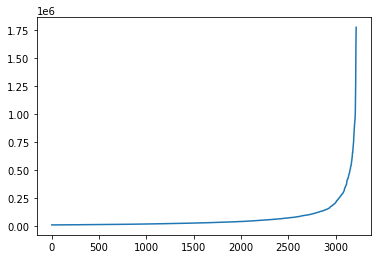

In [ ]:
plt.plot(views)
plt.show()

In [ ]:
num_views_hist = 100
views_hist = np.histogram(views, bins = np.linspace(views.min(),views.max(), num_views_hist))
views_hist = views_hist[0].astype(np.int64)
views_hist

array([1805,  625,  355,  240,  168,  134,   93,   90,   59,   40,   40,
         38,   34,   30,   18,   21,   14,   17,   14,    5,   13,    8,
          6,    6,    3,    7,    6,    4,    4,    5,    2,    7,    7,
          5,    3,    8,    3,    5,    6,    4,    2,    3,    4,    4,
          1,    1,    1,    4,    2,    1,    2,    0,    1,    2,    3,
          0,    0,    1,    1,    2,    0,    2,    1,    0,    0,    0,
          0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2])

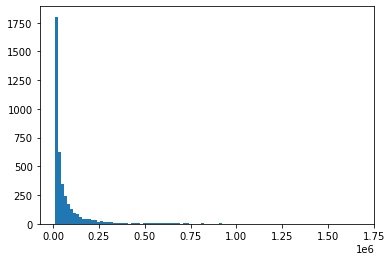

In [ ]:
plt.hist(views, bins = num_views_hist)#np.linspace(0,len(views), 7)
plt.show()

# Создание датасета

In [6]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# counter = 0
# for i in news:
#     if i['link'].find('sport.ria.ru')!=-1:
#         counter+=1
# counter

In [15]:
data = pd.DataFrame(topic_news_dict)
data.head()

,time,date,link,headline,tag,text
0,00:16,1 апреля 2020,https://lenta.ru/news/2020/04/01/pension/,В России выросли минимальные пенсии,Экономика,В России с 1 апреля 2020 года социальные пенси...
1,00:51,1 апреля 2020,https://lenta.ru/news/2020/04/01/gosdep/,В США от коронавируса впервые умер чиновник Го...,Мир,В США впервые умер чиновник Госдепартамента от...
2,02:00,1 апреля 2020,https://lenta.ru/news/2020/04/01/student/,Врачи несколько раз отказали студенту в тесте ...,Из жизни,Врачи отказались проверять студента американск...
3,02:47,1 апреля 2020,https://lenta.ru/news/2020/04/01/trump/,Трамп приготовился решать проблемы на рынке не...,Экономика,"США, Россия и Саудовская Аравия будут вместе и..."
4,03:23,1 апреля 2020,https://lenta.ru/news/2020/04/01/twoweeks/,Трамп предупредил о двух тяжелых неделях,Мир,"Президент США Дональд Трамп предупредил, что с..."


In [ ]:
len(data)

7809

In [16]:
# data.to_csv(md+"data/news_10_2020.csv", index = False)
data.to_pickle(md+"data/news_lenta_04_2020")

In [ ]:
 data_1 = pd.read_pickle(md+'data/news_lenta_12_2020')
 data_1

,time,date,link,headline,tag,text
0,00:05,1 декабря 2020,https://lenta.ru/news/2020/12/01/nervy/,Врач описал поражения центральной нервной сист...,Россия,При COVID-19 довольно часто могут происходить ...
1,00:13,1 декабря 2020,https://lenta.ru/news/2020/11/30/neft/,Цены на нефть показали рекордные темпы роста с...,Экономика,Мировые цены на нефть в ноябре показали рекорд...
2,00:48,1 декабря 2020,https://lenta.ru/news/2020/12/01/dscrmntn/,Авиакомпания Кипра прекратила продажу билетов ...,Путешествия,Авиакомпания Cyprus Airways объявила об отмене...
3,01:20,1 декабря 2020,https://lenta.ru/news/2020/12/01/dolgi/,В Госдуме возмутились отказом Молдавии возвращ...,Россия,В Госдуме возмутились отказом Молдавии возвращ...
4,01:56,1 декабря 2020,https://lenta.ru/news/2020/12/01/opek/,Встречу ОПЕК+ перенесли,Экономика,"Страны ОПЕК+ перенесли на 3 декабря встречу, к..."
...,...,...,...,...,...,...
8112,20:55,31 декабря 2020,https://lenta.ru/news/2020/12/31/bro/,Сербия зарегистрировала российскую вакцину от ...,Мир,Сербское Агентство по медикаментам выдало разр...
8113,21:55,31 декабря 2020,https://lenta.ru/news/2020/12/31/sverh/,Джонсон пообещал превратить Великобританию в н...,Мир,Премьер-министр Великобритании Борис Джонсон в...
8114,22:36,31 декабря 2020,https://lenta.ru/news/2020/12/31/papa/,Папа Римский пропустил новогоднюю службу из-за...,Мир,Папа Римский Франциск пропустил новогоднюю слу...
8115,23:29,31 декабря 2020,https://lenta.ru/news/2020/12/31/suleimani/,США укрепили военную базу в Ираке в преддверии...,Мир,Пентагон усилил периметр военной базы Айн аль-...


In [ ]:
data.index = np.arange(len(data))

In [ ]:
# data = pd.read_csv("last_week.csv")
data = pd.read_pickle(md+"data/january_month")
data.head()

,date,time,views,headline,link,tags,text
0,31 декабря 2020,23:55,13334,Алиев ответил на обвинения ЮНЕСКО из-за армянс...,https://ria.ru/20201231/pamyatniki-1591740604....,"[Ситуация в Нагорном Карабахе, Никол Пашинян, ...","БАКУ, 31 дек – РИА Новости. Президент Азербайд..."
1,31 декабря 2020,23:19,40433,ВОЗ внесла вакцину Pfizer в список для экстрен...,https://ria.ru/20201231/vaktsina-1591739960.html,"[Распространение коронавируса, Панамериканская...","МОСКВА, 31 дек - РИА Новости. Всемирная органи..."
2,31 декабря 2020,21:42,42263,В Сургуте Дед Мороз разбился в ДТП,https://ria.ru/20201231/dtp-1591738065.html,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...","МОСКВА, 31 дек — РИА Новости. Мужчина в костюм..."
3,31 декабря 2020,21:16,29885,В Москве задержали или отменили около 105 рейсов,https://ria.ru/20201231/reys-1591737184.html,"[Домодедово (аэропорт), Шереметьево (аэропорт)...","МОСКВА, 31 дек — РИА Новости. В московских аэр..."
4,31 декабря 2020,20:07,455876,Депутат Рады надел шапку с красной звездой и о...,https://ria.ru/20201231/shapka-1591735431.html,"[Оппозиционная платформа - За жизнь, Ситуация ...","МОСКВА, 31 дек — РИА Новости. Депутат Рады от ..."


In [ ]:
data.tags[0]

['Ситуация в Нагорном Карабахе',
 'Никол Пашинян',
 'ЮНЕСКО',
 'Ильхам Алиев',
 'Москва',
 'Азербайджан',
 'Армения',
 'В мире']

# Тесты

In [ ]:
import numpy as np
n=1000000

%timeit

a=np.array(range(n))
b=np.array(range(0,n*2,2))

def sum_c():
  c = np.zeros(n)
  for i in range(n):
      c[i] = a[i] + b[i]
  return c
sum_c()

array([0.000000e+00, 3.000000e+00, 6.000000e+00, ..., 2.999991e+06,
       2.999994e+06, 2.999997e+06])

In [ ]:
!pip install numba

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
from numba import cuda # Библиотека Nvidia для работы с GPU 
import numpy as np 

@cuda.jit('void(float32[:], float32[:], float32[:])') #Динамический компилятор Cuda 
def cuda_addition(a,b,c):
    """Поток будет выполнять эту функцию ядра."""
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # Отображение потока на индекс массива
    if i > c.size:
        return
    c[i] = a[i]+b[i] #Perform the addition
 
# Подробности об устройстве
device = cuda.get_current_device()

device

In [ ]:
# Перенос с хоста на устройство
d_a = cuda.to_device(a)  # Перенос данных в глобальную память GPU
d_b = cuda.to_device(b)  # Перенос данных в глобальную память GPU
d_c = cuda.device_array_like(a)

tpb = device.WARP_SIZE       #blocksize или количество потоков на блок, стандартное значение = 32
bpg = int(np.ceil((n)/tpb))  # блоков на грид

cuda_addition[bpg, tpb](d_a, d_b, d_c) # вызов ядра

# Перенос вывода с устройства на хост
c = d_c.copy_to_host()
print(c)

In [ ]:
import threading
import time

flag1=False
flag2=False

def print_time( threadName, delay):
   count = 0
   while count < 5:
      time.sleep(delay)
      count += 1
      print ("%s: %s: %s" % ( count, threadName, time.ctime(time.time()) ))
   

not_started_threads = time.time()

t1=threading.Thread(target=print_time, args= ("Thread-1", 0.1,) )
t2=threading.Thread(target= print_time, args=("Thread-2", 0.2,) )

t1.start()
t2.start()

print(t1,t2)


t1.join()
t2.join()

print(time.time() - not_started_threads)

<Thread(Thread-11, started 140177633539840)> <Thread(Thread-12, started 140177616754432)>
1: Thread-1: Mon Feb  8 16:43:52 2021
1: Thread-2: Mon Feb  8 16:43:52 2021
2: Thread-1: Mon Feb  8 16:43:52 2021
3: Thread-1: Mon Feb  8 16:43:52 2021
2: Thread-2: Mon Feb  8 16:43:52 2021
4: Thread-1: Mon Feb  8 16:43:52 2021
5: Thread-1: Mon Feb  8 16:43:52 2021
3: Thread-2: Mon Feb  8 16:43:52 2021
4: Thread-2: Mon Feb  8 16:43:52 2021
5: Thread-2: Mon Feb  8 16:43:52 2021
1.0066328048706055


In [ ]:
def fl( flag):
  global flag.name()
  flag=not flag
  print(flag)

print(flag1)
fl(flag1)
print(flag1)

SyntaxError: ignored

In [ ]:
global w
    print(w)
    w = 20